In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import random
import pickle
import seaborn as sns
import math
import sys

### Reads the data into a dataframe and renames the columns to remove unnecessary numbers 

In [3]:
data_df = pd.read_excel("https://ftp.ncbi.nlm.nih.gov/geo/series/\
GSE124nnn/GSE124548/suppl/\
GSE124548_AllData_170308_RNAseq_Kopp_Results.xlsx")

In [4]:
data_df.shape

(15570, 140)

In [7]:
data_df = data_df.rename(columns=lambda x: re.sub("w_[0-9]+_O", "w_O",x))
data_df = data_df.rename(columns=lambda x: re.sub("m_[0-9]+_O", "m_O",x))

In [8]:
columns = list(data_df.columns) 
columns[:5]

['RowID', 'ID', 'Description', 'EntrezID', 'Class']

In [9]:
raw_cols = [x for x in columns if "Raw" in x] # get all raw values
raw_cols_sums = data_df[raw_cols].sum()
norm_cpm = [data_df[raw_cols].iloc[i]*1000000/raw_cols_sums \
            for i in range(data_df.shape[0])]

In [10]:
norm_cpm_df = pd.DataFrame(data=norm_cpm)
norm_cpm_df.shape

(15570, 60)

In [11]:
norm_cpm_df = pd.concat([norm_cpm_df, data_df[columns[:9]]], axis=1)
norm_cpm_df.head()


,Raw_10_HC_Auto_066_237,Raw_Orkambi_006_Base,Raw_Orkambi_007_V2,Raw_13_HC_Auto_068_239,Raw_Orkambi_007_Base,Raw_Orkambi_009_V2,Raw_16_HC_Auto_072_243,Raw_Orkambi_009_Base,Raw_Orkambi_010_V2,Raw_19_HC_Auto_074_245,...,Raw_Orkambi_026_V2,RowID,ID,Description,EntrezID,Class,pre_drug.vs.control_ShrunkenLog2FC,pre_drug.vs.control_MLELog2FC,pre_drug.vs.control_pVal,pre_drug.vs.control_pAdj
0,3.573084,2.084737,4.012814,2.405698,2.554380,5.560526,3.970076,3.336330,2.125438,4.603163,...,3.045395,1,A1BG,alpha-1-B glycoprotein,1,protein_coding,-0.050497,-0.066327,0.691693,0.824882
1,2.161495,1.700706,3.009610,1.359742,1.516663,2.439823,2.540848,1.811150,1.121759,2.478626,...,2.305799,2,A1BG-AS1,A1BG antisense RNA 1,503538,lncRNA,0.004178,0.032895,0.971929,0.986309
2,3.264299,5.925042,2.221379,2.457996,1.636400,0.879471,3.334864,1.072392,1.859759,8.940759,...,1.435686,3,A2M-AS1,A2M antisense RNA 1 (head to head),144571,lncRNA,0.356337,0.932311,0.050847,0.179776
3,7.102057,4.718089,7.058253,4.811396,4.629815,4.056914,7.717827,3.241006,4.457517,6.594917,...,5.264183,4,AAAS,aladin WD repeat nucleoporin,8086,protein_coding,-0.139005,-0.152091,0.285215,0.495514
4,8.778318,7.022272,7.094081,6.118841,6.465776,7.461318,6.923812,5.790915,5.933516,6.727700,...,6.830386,5,AACS,acetoacetyl-CoA synthetase,65985,protein_coding,0.138032,0.143003,0.088856,0.251817


In [12]:
norm_cpm_df.iloc[:,:5].sum()

Raw_10_HC_Auto_066_237    1000000.0
Raw_Orkambi_006_Base      1000000.0
Raw_Orkambi_007_V2        1000000.0
Raw_13_HC_Auto_068_239    1000000.0
Raw_Orkambi_007_Base      1000000.0
dtype: float64

## Find out how many genes have zeroes

In [13]:
number_of_zeroes = [ list(norm_cpm_df[raw_cols].values[i]).count(0) for i in range(norm_cpm_df.shape[0])]
genes_no_zeroes_logic = [number_of_zeroes[i] == 0 for i in range(len(number_of_zeroes))]

Keep only genes with no zeroes

In [14]:
data_df_subset = norm_cpm_df[genes_no_zeroes_logic]
data_df_subset.shape

(15250, 69)

In [15]:
data_df_subset.head()

,Raw_10_HC_Auto_066_237,Raw_Orkambi_006_Base,Raw_Orkambi_007_V2,Raw_13_HC_Auto_068_239,Raw_Orkambi_007_Base,Raw_Orkambi_009_V2,Raw_16_HC_Auto_072_243,Raw_Orkambi_009_Base,Raw_Orkambi_010_V2,Raw_19_HC_Auto_074_245,...,Raw_Orkambi_026_V2,RowID,ID,Description,EntrezID,Class,pre_drug.vs.control_ShrunkenLog2FC,pre_drug.vs.control_MLELog2FC,pre_drug.vs.control_pVal,pre_drug.vs.control_pAdj
0,3.573084,2.084737,4.012814,2.405698,2.554380,5.560526,3.970076,3.336330,2.125438,4.603163,...,3.045395,1,A1BG,alpha-1-B glycoprotein,1,protein_coding,-0.050497,-0.066327,0.691693,0.824882
1,2.161495,1.700706,3.009610,1.359742,1.516663,2.439823,2.540848,1.811150,1.121759,2.478626,...,2.305799,2,A1BG-AS1,A1BG antisense RNA 1,503538,lncRNA,0.004178,0.032895,0.971929,0.986309
2,3.264299,5.925042,2.221379,2.457996,1.636400,0.879471,3.334864,1.072392,1.859759,8.940759,...,1.435686,3,A2M-AS1,A2M antisense RNA 1 (head to head),144571,lncRNA,0.356337,0.932311,0.050847,0.179776
3,7.102057,4.718089,7.058253,4.811396,4.629815,4.056914,7.717827,3.241006,4.457517,6.594917,...,5.264183,4,AAAS,aladin WD repeat nucleoporin,8086,protein_coding,-0.139005,-0.152091,0.285215,0.495514
4,8.778318,7.022272,7.094081,6.118841,6.465776,7.461318,6.923812,5.790915,5.933516,6.727700,...,6.830386,5,AACS,acetoacetyl-CoA synthetase,65985,protein_coding,0.138032,0.143003,0.088856,0.251817


In [16]:
number_of_zeroes_confirm = [ list(data_df_subset[raw_cols].values[i]).count(0) for i in range(data_df_subset.shape[0])]
[ print(str(y)+" "+str(number_of_zeroes_confirm[y])) for y in range(len(number_of_zeroes_confirm)) if number_of_zeroes_confirm[y] > 0]

[]

In [17]:
healthy = [x for x in data_df_subset.columns if "HC" in x] # healthy control norm values
cf_base = [x for x in data_df_subset.columns if "Base" in x] # cf without treatment
cf_v2 = [x for x in data_df_subset.columns if "V2" in x] # cf with treatment


In [18]:
healthy

['Raw_10_HC_Auto_066_237',
 'Raw_13_HC_Auto_068_239',
 'Raw_16_HC_Auto_072_243',
 'Raw_19_HC_Auto_074_245',
 'Raw_21_HC_Immune_004',
 'Raw_23_HC_Auto_076_247',
 'Raw_26_HC_Auto_078_249',
 'Raw_29_HC_Auto_080_251',
 'Raw_3_HC_Auto_062_233',
 'Raw_42_HC_Auto_089_261',
 'Raw_4_HC_Immune_002',
 'Raw_7_HC_Auto_064_235',
 'Raw_HC_Auto_082_253',
 'Raw_HC_Auto_084_255',
 'Raw_HC_Auto_088_259',
 'Raw_HC_Auto_091_263',
 'Raw_HC_Auto_093_265',
 'Raw_HC_Auto_095_267',
 'Raw_HC_Immune_006',
 'Raw_HC_Immune_008']

In [19]:
def shuffle(grps):
	num_grps = len(grps)
	pool = []
	
	# pool all values
	for i in range(num_grps):
		pool.extend(grps[i])
	# mix them up
	random.shuffle(pool)
	# reassign to groups of same size as original groups
	new_grps = []
	start_index = 0
	end_index = 0
	for i in range(num_grps):
		end_index = start_index + len(grps[i])
		new_grps.append(pool[start_index:end_index])
		start_index = end_index
	return new_grps

In [20]:
shuffle([[1,2,3,4],[5,6,7,8]])

[[1, 4, 3, 2], [8, 5, 7, 6]]

In [21]:
def meandiff(grpA, grpB):
	return sum(grpB) / float(len(grpB)) - sum(grpA) / float(len(grpA))

In [22]:
meandiff([2,2,2],[8,8,8])

6.0

In [23]:
def meanlogFC(grpA, grpB):
    return math.log2( (sum(grpB) / float(len(grpB))) / (sum(grpA) / float(len(grpA))))

In [24]:
meanlogFC([2,2,2],[8,8,8])

2.0

In [25]:
def diff2meansig(grpA, grpB):

    # list of lists
    samples = [grpA, grpB]
    a = 0
    b = 1

    observed_mean_diff = meandiff(samples[a], samples[b])
    all_mean_diffs = []

    count = 0
    num_shuffles = 100000

    for i in range(num_shuffles):
        new_samples = shuffle(samples)
        mean_diff = meandiff(new_samples[a], new_samples[b])
        all_mean_diffs.append(mean_diff)
        # if the observed difference is negative, look for differences that are smaller
        # if the observed difference is positive, look for differences that are greater        
        #if observed_mean_diff < 0 and mean_diff < observed_mean_diff:
        #    count = count + 1
        #elif observed_mean_diff >= 0 and mean_diff >= observed_mean_diff:
        #    count = count + 1
        if abs(observed_mean_diff) <= abs(mean_diff):
            count = count + 1
    
    return count/num_shuffles

In [26]:
def lfc2meansig(grpA, grpB):

    # list of lists
    samples = [grpA, grpB]
    a = 0
    b = 1

    observed_mean_diff = meanlogFC(samples[a], samples[b])
    #all_mean_diffs = []

    count = 0
    num_shuffles = 100000

    for i in range(num_shuffles):
        new_samples = shuffle(samples)
        mean_diff = meanlogFC(new_samples[a], new_samples[b])
        #all_mean_diffs.append(mean_diff)
        # if the observed difference is negative, look for differences that are smaller
        # if the observed difference is positive, look for differences that are greater
        #if observed_mean_diff < 0 and mean_diff <= observed_mean_diff:
        #    count = count + 1
        #elif observed_mean_diff >= 0 and mean_diff >= observed_mean_diff:
        #    count = count + 1
        if abs(observed_mean_diff) <= abs(mean_diff):
            count = count + 1
    
    return count/num_shuffles

In [27]:
def avg_diff_sig_test(df_norm_hc, df_norm_cf):
    fullzip = list(zip(df_norm_hc.values, df_norm_cf.values))
    #print(fullzip[0][1])
    #all_p_sig_values = [diff2meansig(fullzip[i][0],fullzip[i][1]) for i in range(100)]
    #all_p_sig_values = [diff2meansig(fullzip[i][0],fullzip[i][1]) for i in range(len(fullzip))]
    all_p_sig_values = [lfc2meansig(fullzip[i][0],fullzip[i][1]) for i in range(len(fullzip))]
    
    return list(all_p_sig_values)

In [28]:
data_df_subset[healthy].head()

,Raw_10_HC_Auto_066_237,Raw_13_HC_Auto_068_239,Raw_16_HC_Auto_072_243,Raw_19_HC_Auto_074_245,Raw_21_HC_Immune_004,Raw_23_HC_Auto_076_247,Raw_26_HC_Auto_078_249,Raw_29_HC_Auto_080_251,Raw_3_HC_Auto_062_233,Raw_42_HC_Auto_089_261,Raw_4_HC_Immune_002,Raw_7_HC_Auto_064_235,Raw_HC_Auto_082_253,Raw_HC_Auto_084_255,Raw_HC_Auto_088_259,Raw_HC_Auto_091_263,Raw_HC_Auto_093_265,Raw_HC_Auto_095_267,Raw_HC_Immune_006,Raw_HC_Immune_008
0,3.573084,2.405698,3.970076,4.603163,3.789697,2.031677,3.191271,4.895554,3.583114,2.633735,2.992650,2.828261,5.620358,3.027327,2.338965,3.825157,3.163328,3.720840,3.684246,5.142579
1,2.161495,1.359742,2.540848,2.478626,2.526465,2.062460,2.260484,2.864065,2.177082,1.850733,2.272197,2.510081,2.767601,1.602702,1.611990,2.142088,2.757029,1.766460,1.902853,2.041329
2,3.264299,2.457996,3.334864,8.940759,2.947542,2.493422,4.033412,3.663339,1.678167,2.989645,5.098589,2.686848,3.023071,1.869819,4.614716,3.404390,4.904609,4.510110,3.198412,1.648766
3,7.102057,4.811396,7.717827,6.594917,6.348553,6.433644,5.451755,7.559800,6.894092,5.125106,6.982851,6.611059,7.493811,4.540990,3.223979,3.327887,5.920357,4.434941,4.574943,3.415300
4,8.778318,6.118841,6.923812,6.727700,6.704849,5.417805,6.471189,6.760526,5.760196,5.658972,7.758723,5.727228,8.047331,6.232731,5.562945,6.579271,8.271087,7.291344,8.704538,6.320269


In [37]:
import time
a = time.time()
norm_p_values = avg_diff_sig_test(data_df_subset[healthy], data_df_subset[cf_base])
b = time.time()
print(b - a)

49777.931671619415


In [40]:
pickle.dump( norm_p_values, open( "norm_p_values_unpaired_raw.p", "wb" ) )

In [29]:
norm_p_values = pickle.load( open( "norm_p_values_unpaired_raw.p", "rb" ) )

In [30]:
norm_p_values[0:5]

[0.07164, 0.3652, 0.42836, 0.06547, 0.97293]

In [31]:
sig_genes = [i for i in range(len(norm_p_values)) if norm_p_values[i] < 0.05]
len(sig_genes)

7361

In [32]:
sig_gene_names=data_df_subset.ID.iloc[sig_genes]

In [33]:
sig_gene_names[:10]

5        AAED1
6        AAGAB
9         AAMP
11        AARS
12       AARS2
13       AASDH
14    AASDHPPT
15        AASS
17        AATK
18      ABALON
Name: ID, dtype: object

**Bonferroni correction**

In this method, we divide the threshold by the number of genes. So, if we take a default threshold of 5% (or 0.05), now our threshold would be `0.05/len(norm_p_values)`

Bonferroni may just be all genes that have only 0.
 - count the number of p-values that are 0
violin plot of a set, 5-10 genes to see if they are really separate. 
confirm that their diagnostics are also present here.
Take top 5 genes to do machine learning.
 - do decision tree and random forest


In [34]:
count_significant_genes_bonferroni = 0
for i, ele in enumerate(norm_p_values):
  if ele < (0.2/len(norm_p_values)):
    count_significant_genes_bonferroni += 1
    #print(i+1)
print("Number of significant genes: ", count_significant_genes_bonferroni)

Number of significant genes:  531


In [35]:
0.2/len(norm_p_values)

1.3114754098360657e-05

In [36]:
norm_p_values.count(0)

366

In [37]:
#sum(norm_p_values < 0.2/len(norm_p_values))
sig_bon_genes = [True if norm_p_values[i] < 0.2/len(norm_p_values) else False for i in range(len(norm_p_values))]

In [38]:
sum(sig_bon_genes)

531

In [39]:
#tmp_sorted_indices = np.argsort(norm_p_values)
#bon_sig_index = tmp_sorted_indices[:norm_p_values.count(0)]

#bon_sig_genes = [data_df_subset["ID"].iloc[bon_sig_index[i]] for i in range(len(bon_sig_index))]
bon_sig_genes = data_df_subset[sig_bon_genes]["ID"]
bon_sig_genes[:5]

13     AASDH
94     ACADS
141    ACSL1
143    ACSL4
144    ACSL5
Name: ID, dtype: object

In [40]:
bon_sig_genes.shape

(531,)

**Benjamini–Hochberg procedure**

 Put the individual P values in order, from smallest to largest. The smallest P value has a rank of i=1, then next smallest has i=2, etc. Compare each individual P value to its Benjamini-Hochberg critical value, (i/m)Q, where i is the rank, m is the total number of tests, and Q is the false discovery rate you choose. The largest P value that has P<(i/m)Q is significant, and all of the P values smaller than it are also significant, even the ones that aren't less than their Benjamini-Hochberg critical value.

In [41]:
def benjamin_hochberg_corrected_p_values(p_values, fdr):
  num_genes = len(p_values)
  sorted_indices = np.argsort(p_values)
  sorted_p_values = sorted(p_values)
  benjamini_hochberg_critical_values = [((i+1)/num_genes)*fdr for i in range(num_genes)]
  for i, p_value in reversed(list(enumerate(sorted_p_values))):
    #print(str(p_value) + " " + str(benjamini_hochberg_critical_values[i])+" " + str(i)+ "\n")
    if p_value < benjamini_hochberg_critical_values[i]:
      break
  return i, sorted_indices

In [42]:
i, sorted_indices = benjamin_hochberg_corrected_p_values(norm_p_values, 0.05)
num_fdr_sig_genes = i+1
print("Number of significant genes: ", num_fdr_sig_genes)

Number of significant genes:  6073


In [43]:
significant_genes = []

significant_genes = [data_df_subset["ID"].iloc[sorted_indices[i]] for i in range(num_fdr_sig_genes)]
significant_genes[:10]

['CCDC107',
 'IL1R1',
 'CSF2RB',
 'PHC2',
 'SRSF8',
 'IL1R2',
 'SRSF7',
 'PHF20L1',
 'PHF21A',
 'AEN']

In [44]:
print(data_df_subset.loc[data_df_subset['ID'].isin(significant_genes)][['RowID', 'ID', 'Description']])

       RowID     ID                                      Description
5          6  AAED1  AhpC/TSA antioxidant enzyme domain containing 1
6          7  AAGAB         alpha- and gamma-adaptin binding protein
9         10   AAMP          angio associated migratory cell protein
11        12   AARS                           alanyl-tRNA synthetase
12        13  AARS2          alanyl-tRNA synthetase 2, mitochondrial
...      ...    ...                                              ...
15560  15561   ZW10                         zw10 kinetochore protein
15562  15563  ZWINT             ZW10 interacting kinetochore protein
15563  15564   ZXDA              zinc finger, X-linked, duplicated A
15567  15568    ZYX                                            zyxin
15569  15570   ZZZ3                 zinc finger ZZ-type containing 3

[6073 rows x 3 columns]


In [45]:
#draw histogram

def draw_hist(d, observed):
    print(observed)
    hist,bin_edges = np.histogram(d,bins =100)    
    plt.figure(figsize=[8,8])
    plt.bar(bin_edges[:-1], hist, width = 0.01, color='#0504aa',alpha=0.7)
    #plt.xlim(min(min(bin_edges),-4), max(max(bin_edges),4))
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value',fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.title('Normal Distribution Histogram',fontsize=15)
    plt.axvline(x=observed, color='r', linestyle='dashed', linewidth=2)
    plt.show()

0.05


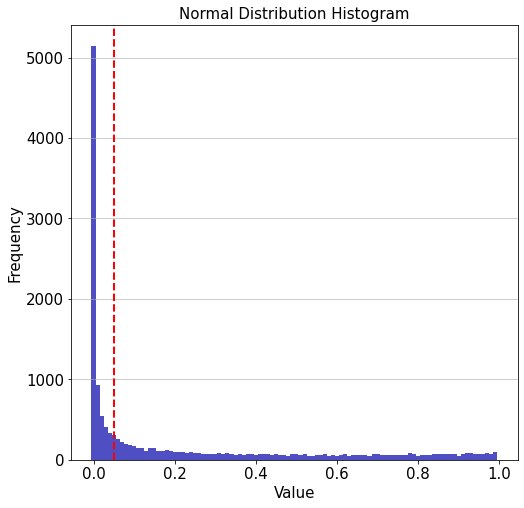

In [46]:
draw_hist(norm_p_values, 0.05)

In [47]:
norm_hc_cf_with_genename = ["ID"]
norm_hc_cf_with_genename.extend(healthy)
norm_hc_cf_with_genename_melt = data_df_subset[norm_hc_cf_with_genename].melt("ID")
norm_hc_cf_with_genename_melt.variable="HC"
#print(norm_hc_cf_with_genename_melt.shape)


norm_cf_with_genename = ["ID"]
norm_cf_with_genename.extend(cf_base)
norm_cf_with_genename_melt = data_df_subset[norm_cf_with_genename].melt("ID")
norm_cf_with_genename_melt.variable="CF"
#print(norm_cf_with_genename_melt.shape)

norm_hc_cf_with_genename_melt = norm_hc_cf_with_genename_melt.append(norm_cf_with_genename_melt, ignore_index=True)
norm_hc_cf_with_genename_melt.head()

,ID,variable,value
0,A1BG,HC,3.573084
1,A1BG-AS1,HC,2.161495
2,A2M-AS1,HC,3.264299
3,AAAS,HC,7.102057
4,AACS,HC,8.778318


In [48]:
#list(norm_hc_cf_with_genename_melt.ID.values)

## Violin Plots

In [49]:
#norm_hc_cf_with_genename_melt.


# plot log2fc instead of expression values.


In [50]:
#data_df.iloc(tmp_sorted_indices[0])
#genestoplot=norm_hc_cf_with_genename_melt[norm_hc_cf_with_genename_melt.ID.isin(top_sorted_genes[2:3])]
genestoplot=norm_hc_cf_with_genename_melt[norm_hc_cf_with_genename_melt.ID.isin(bon_sig_genes[2:3])]


<AxesSubplot:xlabel='ID', ylabel='value'>

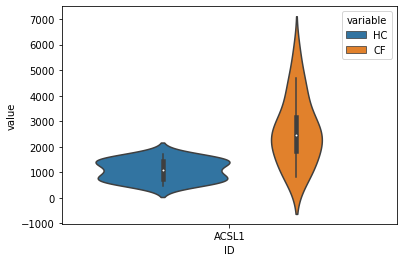

In [51]:
sns.violinplot(x="ID", y="value", hue="variable",data=genestoplot)

In [52]:
tmp_sorted_p_values = sorted(norm_p_values)

In [53]:
tmp_sorted_p_values.count(0)

366

In [54]:
tmp_critical_values = [((i+1)/15000)*0.05 for i in range(15000)]

In [55]:
tmp_critical_values[:10]

[3.3333333333333337e-06,
 6.6666666666666675e-06,
 1e-05,
 1.3333333333333335e-05,
 1.6666666666666667e-05,
 2e-05,
 2.3333333333333336e-05,
 2.666666666666667e-05,
 2.9999999999999997e-05,
 3.3333333333333335e-05]

# Compare results to published.

In [56]:
#np.count_nonzero(abs(2) < abs(a))
published_sig_logic = data_df_subset['pre_drug.vs.control_pAdj'] < 0.05
np.count_nonzero(published_sig_logic)

1944

In [57]:
published_significant_genes = data_df_subset[data_df_subset['pre_drug.vs.control_pAdj'] < 0.05]

In [58]:
#all published significant
len(published_significant_genes.ID)

1944

In [59]:
#overlap with significant
sum(published_significant_genes.ID.isin(sig_gene_names))

1741

In [60]:
#overlap with fdr
sum(published_significant_genes.ID.isin(significant_genes))

1645

In [61]:
#overlap with bonferroni
sum(published_significant_genes.ID.isin(bon_sig_genes))

392

## Compare fdr results with statsmodels function

In [62]:
import statsmodels.stats.multitest as ssm
norm_p_values_np = np.array(norm_p_values, float)

rej, s_adjpval = ssm.multipletests(norm_p_values_np, alpha=0.05, method="s")[:2]
rej, fdr_adjpval = ssm.multipletests(norm_p_values_np, alpha=0.05, method="fdr_i")[:2]

In [63]:
tmp_sorted_s_adjpval = sorted(s_adjpval)
#tmp_sorted_s_adjpval[:10]
sum(np.array(tmp_sorted_s_adjpval)<0.05)

366

In [64]:
tmp_sorted_fdr_adjpval = sorted(fdr_adjpval)
tmp_sorted_fdr_adjpval[530:531]

[0.0002871939736346516]

In [65]:
sum(np.array(tmp_sorted_fdr_adjpval)<0.05)

6073

In [66]:
pd.DataFrame([tmp_sorted_p_values[:10],tmp_sorted_fdr_adjpval[:10],tmp_sorted_s_adjpval[:10]])

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Healthy control vs CF confidence interval

In [67]:
# We will only look at the confidence intervals of the genes that had 0 events.
#data_df_subset[healthy], data_df_subset[cf_base]
data_df_subset_bon = data_df_subset[data_df_subset.ID.isin(bon_sig_genes)]
df_norm_hc_bon_sig = data_df_subset_bon[healthy]
df_norm_cf_bon_sig = data_df_subset_bon[cf_base]
print(df_norm_cf_bon_sig.shape,df_norm_hc_bon_sig.shape)

(531, 20) (531, 20)


In [68]:
def bootstrap(x):
	samp_x = []
	for i in range(len(x)):
		samp_x.append(random.choice(x))
	return samp_x

In [69]:
def diff2meanconf(grpA, grpB, num_resamples):
    # list of lists
    samples = [grpA, grpB] 
    a = 0
    b = 1

    observed_mean_diff = meanlogFC(samples[a], samples[b])
    out = []                # will store results of each time we resample
    for i in range(num_resamples):
        # get bootstrap samples for each of our groups
        # then compute our statistic of interest
        # append statistic to out
        bootstrap_samples = []  # list of lists
        for sample in samples:
            bootstrap_samples.append(bootstrap(sample))
        # now we have a list of bootstrap samples, run meandiff
        out.append(meanlogFC(bootstrap_samples[a], bootstrap_samples[b]))
    out.sort()
    #tails = (1 - conf_interval) / 2
    # in case our lower and upper bounds are not integers,
    # we decrease the range (the values we include in our interval),
    # so that we can keep the same level of confidence
    #lower_bound = int(math.ceil(num_resamples * tails))
    #upper_bound = int(math.floor(num_resamples * (1 - tails)))
    return(out)

In [70]:
diff2meanconf(list(df_norm_hc_bon_sig.values[1]),
              list(df_norm_cf_bon_sig.values[1]),100)

[-1.2249892548347634,
 -1.1369821742301263,
 -1.090667499280174,
 -1.087163693375383,
 -1.0216323457160983,
 -1.0213112122923105,
 -1.011735923022935,
 -0.9882662225107772,
 -0.9873210156694713,
 -0.9626436930006802,
 -0.9622382369436874,
 -0.9557934000980184,
 -0.9517604441968002,
 -0.9394708677296651,
 -0.9121878145665216,
 -0.9083997754778925,
 -0.8986974169378127,
 -0.8969971229406805,
 -0.8940254257601372,
 -0.8872240451759642,
 -0.8756036013407817,
 -0.8719134257730602,
 -0.8702257189853446,
 -0.8698416385523944,
 -0.8689302245825122,
 -0.8643235038096924,
 -0.8620811813250132,
 -0.8607011738061037,
 -0.8604981403299709,
 -0.856112043538171,
 -0.8556701119695702,
 -0.8507044997474182,
 -0.8504481696194442,
 -0.8491726021098331,
 -0.8490198249286891,
 -0.8443519757796695,
 -0.8310031171257564,
 -0.8241469538692635,
 -0.8184236464978683,
 -0.8175850262023662,
 -0.8166400597541016,
 -0.804436967856405,
 -0.8043386253670114,
 -0.8025342679076011,
 -0.7995812415261151,
 -0.79660622394

In [2]:
def diff2meanJustconf(grpA, grpB, conf_interval):
    tails = (1 - conf_interval) / 2
    num_resamples = 1000
    out = diff2meanconf(grpA, grpB, num_resamples)
    # in case our lower and upper bounds are not integers,
    # we decrease the range (the values we include in our interval),
    # so that we can keep the same level of confidence
    lower_bound = int(math.ceil(num_resamples * tails))
    upper_bound = int(math.floor(num_resamples * (1 - tails)))
    return([out[lower_bound], out[upper_bound]])

In [72]:
diff2meanJustconf(list(df_norm_hc_bon_sig.values[1]),
              list(df_norm_cf_bon_sig.values[1]),.90)

[-1.0624404842667725, -0.4544999390896801]

In [84]:
fullzip = list(zip(df_norm_hc_bon_sig.values, df_norm_cf_bon_sig.values))
all_conf_intervals = [diff2meanconf(fullzip[i][0],fullzip[i][1], 0.90) for i in range(len(fullzip))]
   

In [85]:
pickle.dump( all_conf_intervals, open( "all_conf_intervals_raw.p", "wb" ) )

In [73]:
all_conf_intervals = pickle.load( open( "all_conf_intervals_raw.p", "rb" ) )

In [74]:
all_conf_intervals[:5]

[[-0.4614977441185028, -0.2405293804953606],
 [-1.0334666901633853, -0.4695672542849253],
 [0.9148110772483203, 1.5811032630104673],
 [0.36625482966020556, 0.7059376073322905],
 [-0.6039903776088369, -0.3271393923984401]]

In [75]:
max_conf = [abs(max(all_conf_intervals[i], key=abs)) for i in range(len(all_conf_intervals))]

In [76]:
max_conf[:5]

[0.4614977441185028,
 1.0334666901633853,
 1.5811032630104673,
 0.7059376073322905,
 0.6039903776088369]

In [77]:
sorted_max_conf = sorted(max_conf, reverse=True)
sorted_max_conf[:10]

[3.161189532672288,
 2.603696214411879,
 2.4874355245675845,
 2.2398359974692257,
 2.226817255502452,
 2.1579259755626925,
 2.140776879805022,
 2.1017978055178723,
 2.0467853043486666,
 1.9797754393277724]

0


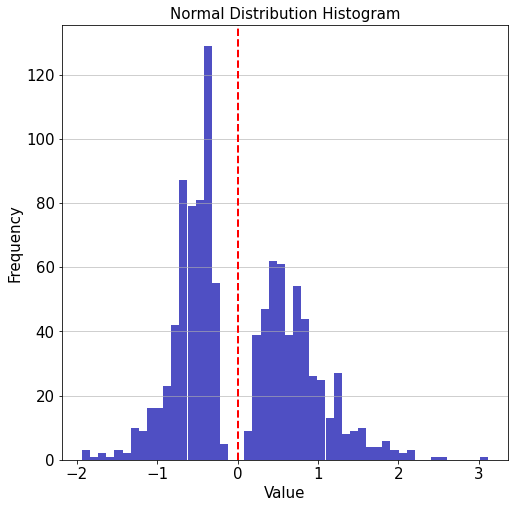

In [78]:
def draw_hist(d, observed):
    print(observed)
    hist,bin_edges = np.histogram(d,bins =50)    
    plt.figure(figsize=[8,8])
    plt.bar(bin_edges[:-1], hist, width = 0.1, color='#0504aa',alpha=0.7)
    #plt.xlim(min(min(bin_edges),-4), max(max(bin_edges),4))
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value',fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.title('Normal Distribution Histogram',fontsize=15)
    plt.axvline(x=observed, color='r', linestyle='dashed', linewidth=2)
    plt.show()
    
draw_hist(all_conf_intervals, 0)

0


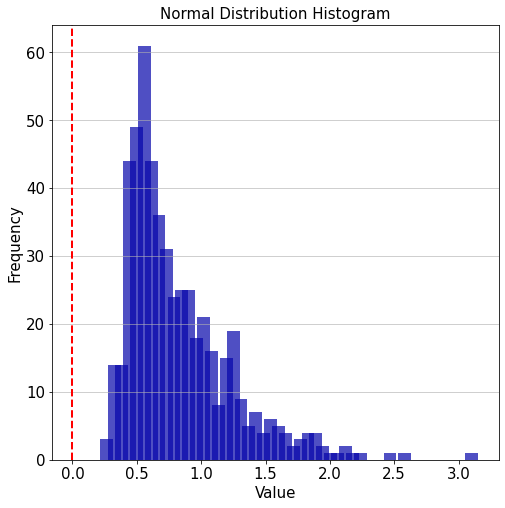

In [79]:
draw_hist(max_conf, 0)

In [80]:
sorted_max_conf_index = np.argsort(max_conf)
top10_conf_index = sorted_max_conf_index[::-1][:10]
top10_conf_index

array([246, 276, 291, 446,  21, 170, 203, 345, 333, 213])

In [81]:
list(top10_conf_index)

[246, 276, 291, 446, 21, 170, 203, 345, 333, 213]

In [82]:
top10_conf_gene_names = data_df_subset_bon.ID.iloc[top10_conf_index]
top10_conf_gene_names

6886     LOC105372578
8139           MCEMP1
8458             MMP9
12605           SOCS3
555             ANXA3
4206             G0S2
5313            IL1R2
9800           PFKFB3
9470              OSM
5496            ITGB4
Name: ID, dtype: object

In [83]:
top10_ci_genes = [data_df_subset_bon["ID"].iloc[top10_conf_index[i]] for i in range(len(top10_conf_index))]

In [84]:
top10_ci_genes

['LOC105372578',
 'MCEMP1',
 'MMP9',
 'SOCS3',
 'ANXA3',
 'G0S2',
 'IL1R2',
 'PFKFB3',
 'OSM',
 'ITGB4']

In [85]:
top10_ci_gene_description = [data_df_subset_bon["Description"].iloc[top10_conf_index[i]] for i in range(len(top10_conf_index))]
top10_ci_gene_description

[nan,
 'mast cell-expressed membrane protein 1',
 'matrix metallopeptidase 9',
 'suppressor of cytokine signaling 3',
 'annexin A3',
 'G0/G1 switch 2',
 'interleukin 1 receptor type 2',
 '6-phosphofructo-2-kinase/fructose-2,6-biphosphatase 3',
 'oncostatin M',
 'integrin subunit beta 4']

In [86]:
top10conf = [all_conf_intervals[i] for i in top10_conf_index]

In [87]:
top10conf

[[1.7614043271106299, 3.161189532672288],
 [1.563696812355711, 2.603696214411879],
 [1.6391422627760681, 2.4874355245675845],
 [1.3865411836826045, 2.2398359974692257],
 [1.3089158487480603, 2.226817255502452],
 [1.3780856441115017, 2.1579259755626925],
 [0.9346586302457188, 2.140776879805022],
 [1.431472480169909, 2.1017978055178723],
 [1.276851455081839, 2.0467853043486666],
 [1.1120525186308732, 1.9797754393277724]]

In [1]:
#diff2meanconf(list(df_norm_hc_bon_sig.values[top10_conf_index[2]]),
#              list(df_norm_cf_bon_sig.values[top10_conf_index[2]]),100)

#norm_hc_cf_with_genename = ["ID"]
#norm_hc_cf_with_genename.extend(healthy)
#norm_hc_cf_with_genename_melt = data_df_subset[norm_hc_cf_with_genename].melt("ID")
#norm_hc_cf_with_genename_melt.variable="HC"

mmp9_bootstrap=diff2meanconf(list(df_norm_hc_bon_sig.values[top10_conf_index[2]]),
              list(df_norm_cf_bon_sig.values[top10_conf_index[2]]),100)
socs3_bootstrap=diff2meanconf(list(df_norm_hc_bon_sig.values[top10_conf_index[3]]),
              list(df_norm_cf_bon_sig.values[top10_conf_index[3]]),100)
anxa_bootstrap=diff2meanconf(list(df_norm_hc_bon_sig.values[top10_conf_index[4]]),
              list(df_norm_cf_bon_sig.values[top10_conf_index[4]]),100)
three_genes_bootstrap = pd.DataFrame({'mmp9':mmp9_bootstrap, 
                                     'socs3':socs3_bootstrap,
                                     'anxa3':anxa_bootstrap})
three_gene_bs_melt = three_genes_bootstrap.melt()
#three_gene_bs_melt.tail()
plt.style.use('seaborn-notebook')
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (6,4), dpi=300, facecolor="white")
plt.rcParams['lines.linewidth']=.5
sns.violinplot(x="variable", y="value",data=three_gene_bs_melt)
plt.title("Expression of Significant Genes")
plt.xlabel("Gene ID")
plt.ylabel("Log fold change values")
plt.ylim(0,3)
plt.legend([],[], frameon=False)
plt.savefig('sig_genes_violin.png')


NameError: name 'diff2meanconf' is not defined

In [91]:
genestoplot=norm_hc_cf_with_genename_melt[norm_hc_cf_with_genename_melt.ID.isin(top10_ci_genes[9:10])]
genestoplot.head()

,ID,variable,value
5399,ITGB4,HC,1.367477
20649,ITGB4,HC,1.307445
35899,ITGB4,HC,1.238664
51149,ITGB4,HC,0.619657
66399,ITGB4,HC,1.295623


<AxesSubplot:xlabel='ID', ylabel='value'>

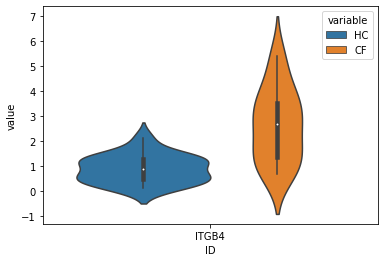

In [126]:
sns.violinplot(x="ID", y="value", hue="variable",data=genestoplot)


<AxesSubplot:xlabel='ID', ylabel='value'>

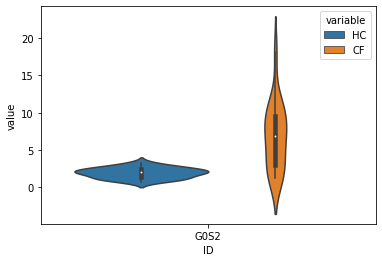

In [127]:
genestoplot=norm_hc_cf_with_genename_melt[norm_hc_cf_with_genename_melt.ID.isin(top10_ci_genes[5:6])]
sns.violinplot(x="ID", y="value", hue="variable",data=genestoplot)


<AxesSubplot:xlabel='ID', ylabel='value'>

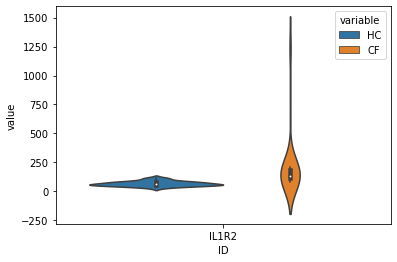

In [128]:
genestoplot=norm_hc_cf_with_genename_melt[norm_hc_cf_with_genename_melt.ID.isin(top10_ci_genes[6:7])]
sns.violinplot(x="ID", y="value", hue="variable",data=genestoplot)


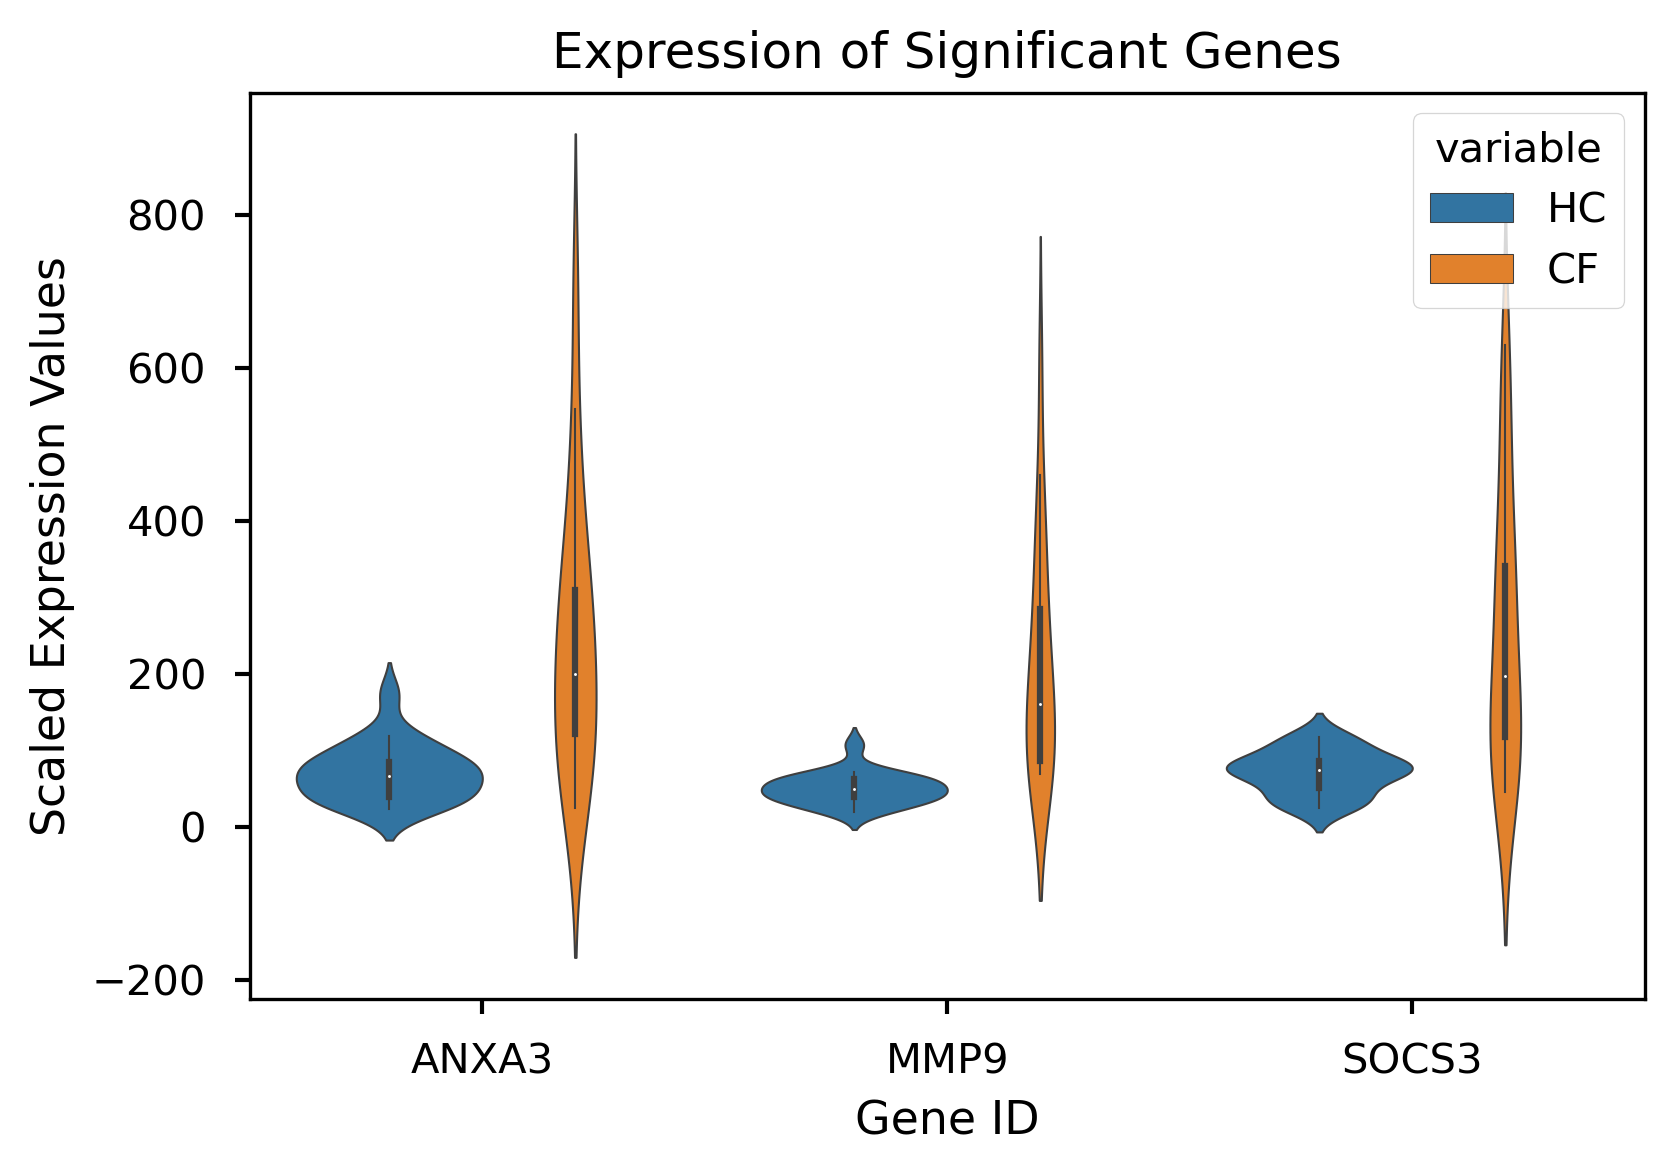

In [168]:
genestoplot=norm_hc_cf_with_genename_melt[norm_hc_cf_with_genename_melt.ID.isin(["MMP9","SOCS3","ANXA3"])]
plt.style.use('seaborn-notebook')
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (6,4), dpi=300, facecolor="white")
plt.rcParams['lines.linewidth']=.5
sns.violinplot(x="ID", y="value", hue="variable",data=genestoplot)
plt.title("Expression of Significant Genes")
plt.xlabel("Gene ID")
plt.ylabel("Scaled Expression Values")
plt.savefig('sig_genes_violin.png')

## Machine Learning Models

First we need to make subset of the dataframe to contain only our top 10 genes

In [129]:
data_df_subset_bon_top10ci = data_df_subset[data_df_subset.ID.isin(top10_ci_genes)]
df_norm_hc_bon_sig_top10ci = data_df_subset_bon_top10ci[healthy]
df_norm_cf_bon_sig_top10ci = data_df_subset_bon_top10ci[cf_base]
print(df_norm_hc_bon_sig_top10ci.shape,df_norm_cf_bon_sig_top10ci.shape)

(10, 20) (10, 20)


In [130]:
top10_ci_genes

['LOC105372578',
 'MCEMP1',
 'MMP9',
 'SOCS3',
 'ANXA3',
 'G0S2',
 'IL1R2',
 'PFKFB3',
 'OSM',
 'ITGB4']

In [131]:
data_df_subset_bon_top10ci["ID"]

555             ANXA3
4206             G0S2
5313            IL1R2
5496            ITGB4
6886     LOC105372578
8139           MCEMP1
8458             MMP9
9470              OSM
9800           PFKFB3
12605           SOCS3
Name: ID, dtype: object

In [132]:
data_df_subset_bon_top10ci.ID.values

array(['ANXA3', 'G0S2', 'IL1R2', 'ITGB4', 'LOC105372578', 'MCEMP1',
       'MMP9', 'OSM', 'PFKFB3', 'SOCS3'], dtype=object)

In [133]:
df_norm_healthy_T = df_norm_hc_bon_sig_top10ci.T
labels_healthy = [1]*20

df_norm_base_T = df_norm_cf_bon_sig_top10ci.T
labels_patient = [0]*20

In [134]:
X1 = df_norm_healthy_T.values
X2 = df_norm_base_T.values
Y1 = np.zeros((1,20))
Y2 = np.ones((1,20))

In [135]:
X = np.concatenate((X1, X2), axis=0)
X.shape

(40, 10)

In [136]:
Y = np.concatenate((Y1, Y2), axis=1)
Y = np.reshape(Y, 40)
Y.shape

(40,)

In [137]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [138]:
test_precision = []
test_recall = []
test_f1 = []
for i in range(100):
    clf = RandomForestClassifier()
    scoring = {'precision': 'precision',
               'recall': 'recall',
              'f1_macro':'f1_macro'}
    scores = cross_validate(clf, X, Y, cv=5, scoring=scoring, return_train_score=True)
    test_precision.append(scores['test_precision'].mean())
    test_recall.append(scores['test_recall'].mean())
    test_f1.append(scores['test_f1_macro'].mean())

In [145]:
sum(test_recall)/len(test_recall)

0.8564999999999996

In [146]:
sum(test_precision)/len(test_precision)

0.9128333333333342

In [147]:
sum(test_f1)/len(test_f1)

0.86918888888889

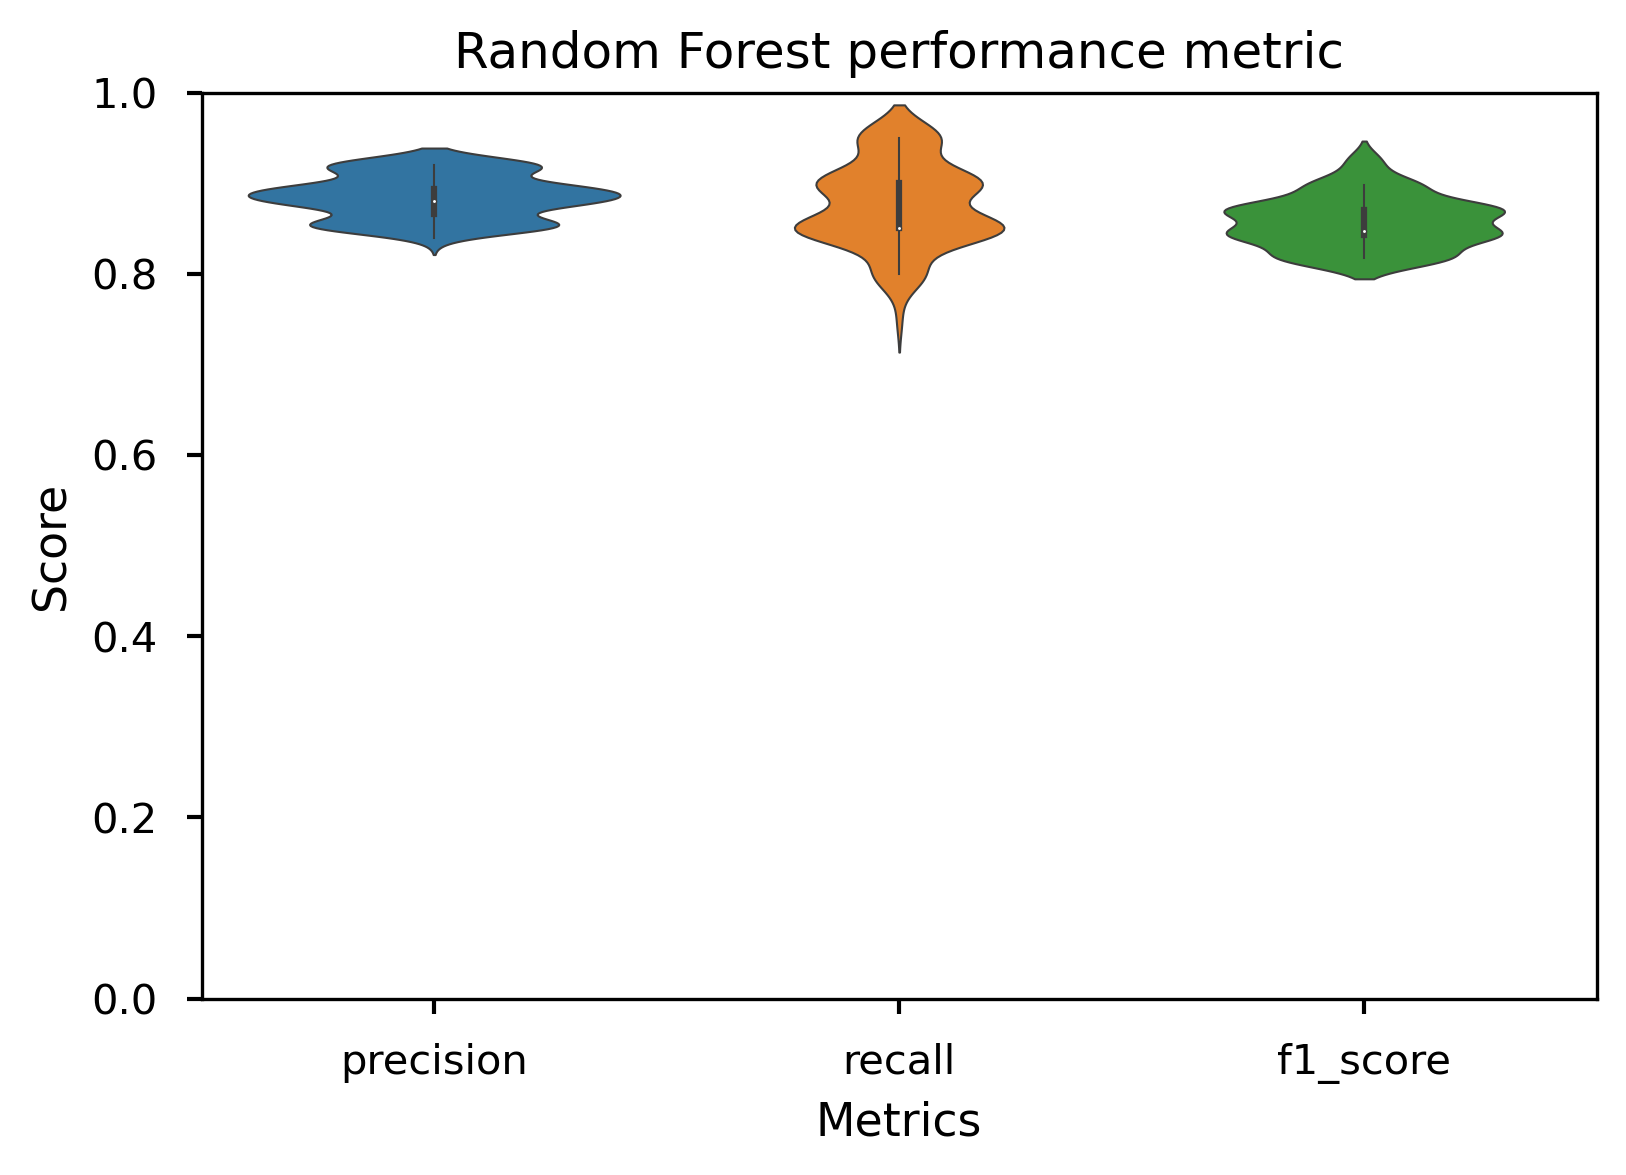

In [192]:
test_stats = {"f1_score" : test_f1,
              "precision": test_precision,
              "recall": test_recall}
test_stats_df = pd.DataFrame(data=test_stats)
test_stats_melt = pd.melt(test_stats_df, value_vars=["precision","recall","f1_score"])
#clf_feature_imp_df
#sns.scatterplot(y="precision", x="recall", data=test_stats_df, estimator=None)
test_stats_melt.iloc[98:105]
# make the axis start from 0.
plt.style.use('seaborn-notebook')
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (6,4), dpi=300, facecolor="white")
plt.rcParams['lines.linewidth']=.5
sns.violinplot(x="variable",y="value",data=test_stats_melt)
plt.title("Random Forest performance metric")
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.ylim(0,1)
plt.savefig('random_forest_rna_seq_performance.png')

In [109]:
# figure caption: Recall and precision of deciding whether someone has cystic fibrosis.
# vertical axis shows precision and horizontal axis shows recall when patients are ordered,
# in descending order of their scores. 
# Thus, we expect higher precision for the patients on the left.
# the average precision is __, average recall ___ ,
# and average f is ____ ( with 90% interval of f )


In [152]:
#clf.feature_importances_

In [111]:
# AUC , PR curve for all 100, provide information of the F score and mean of the 90% interval

In [154]:
important_score = []
important_genes = []
for i in range(100):
    clf = RandomForestClassifier().fit(X, Y)
    important_score.extend(list(clf.feature_importances_))
    important_genes.extend(data_df_subset_bon_top10ci.ID.values)

clf_feature_imp = {"important" : important_score,
                   "genes" : important_genes}


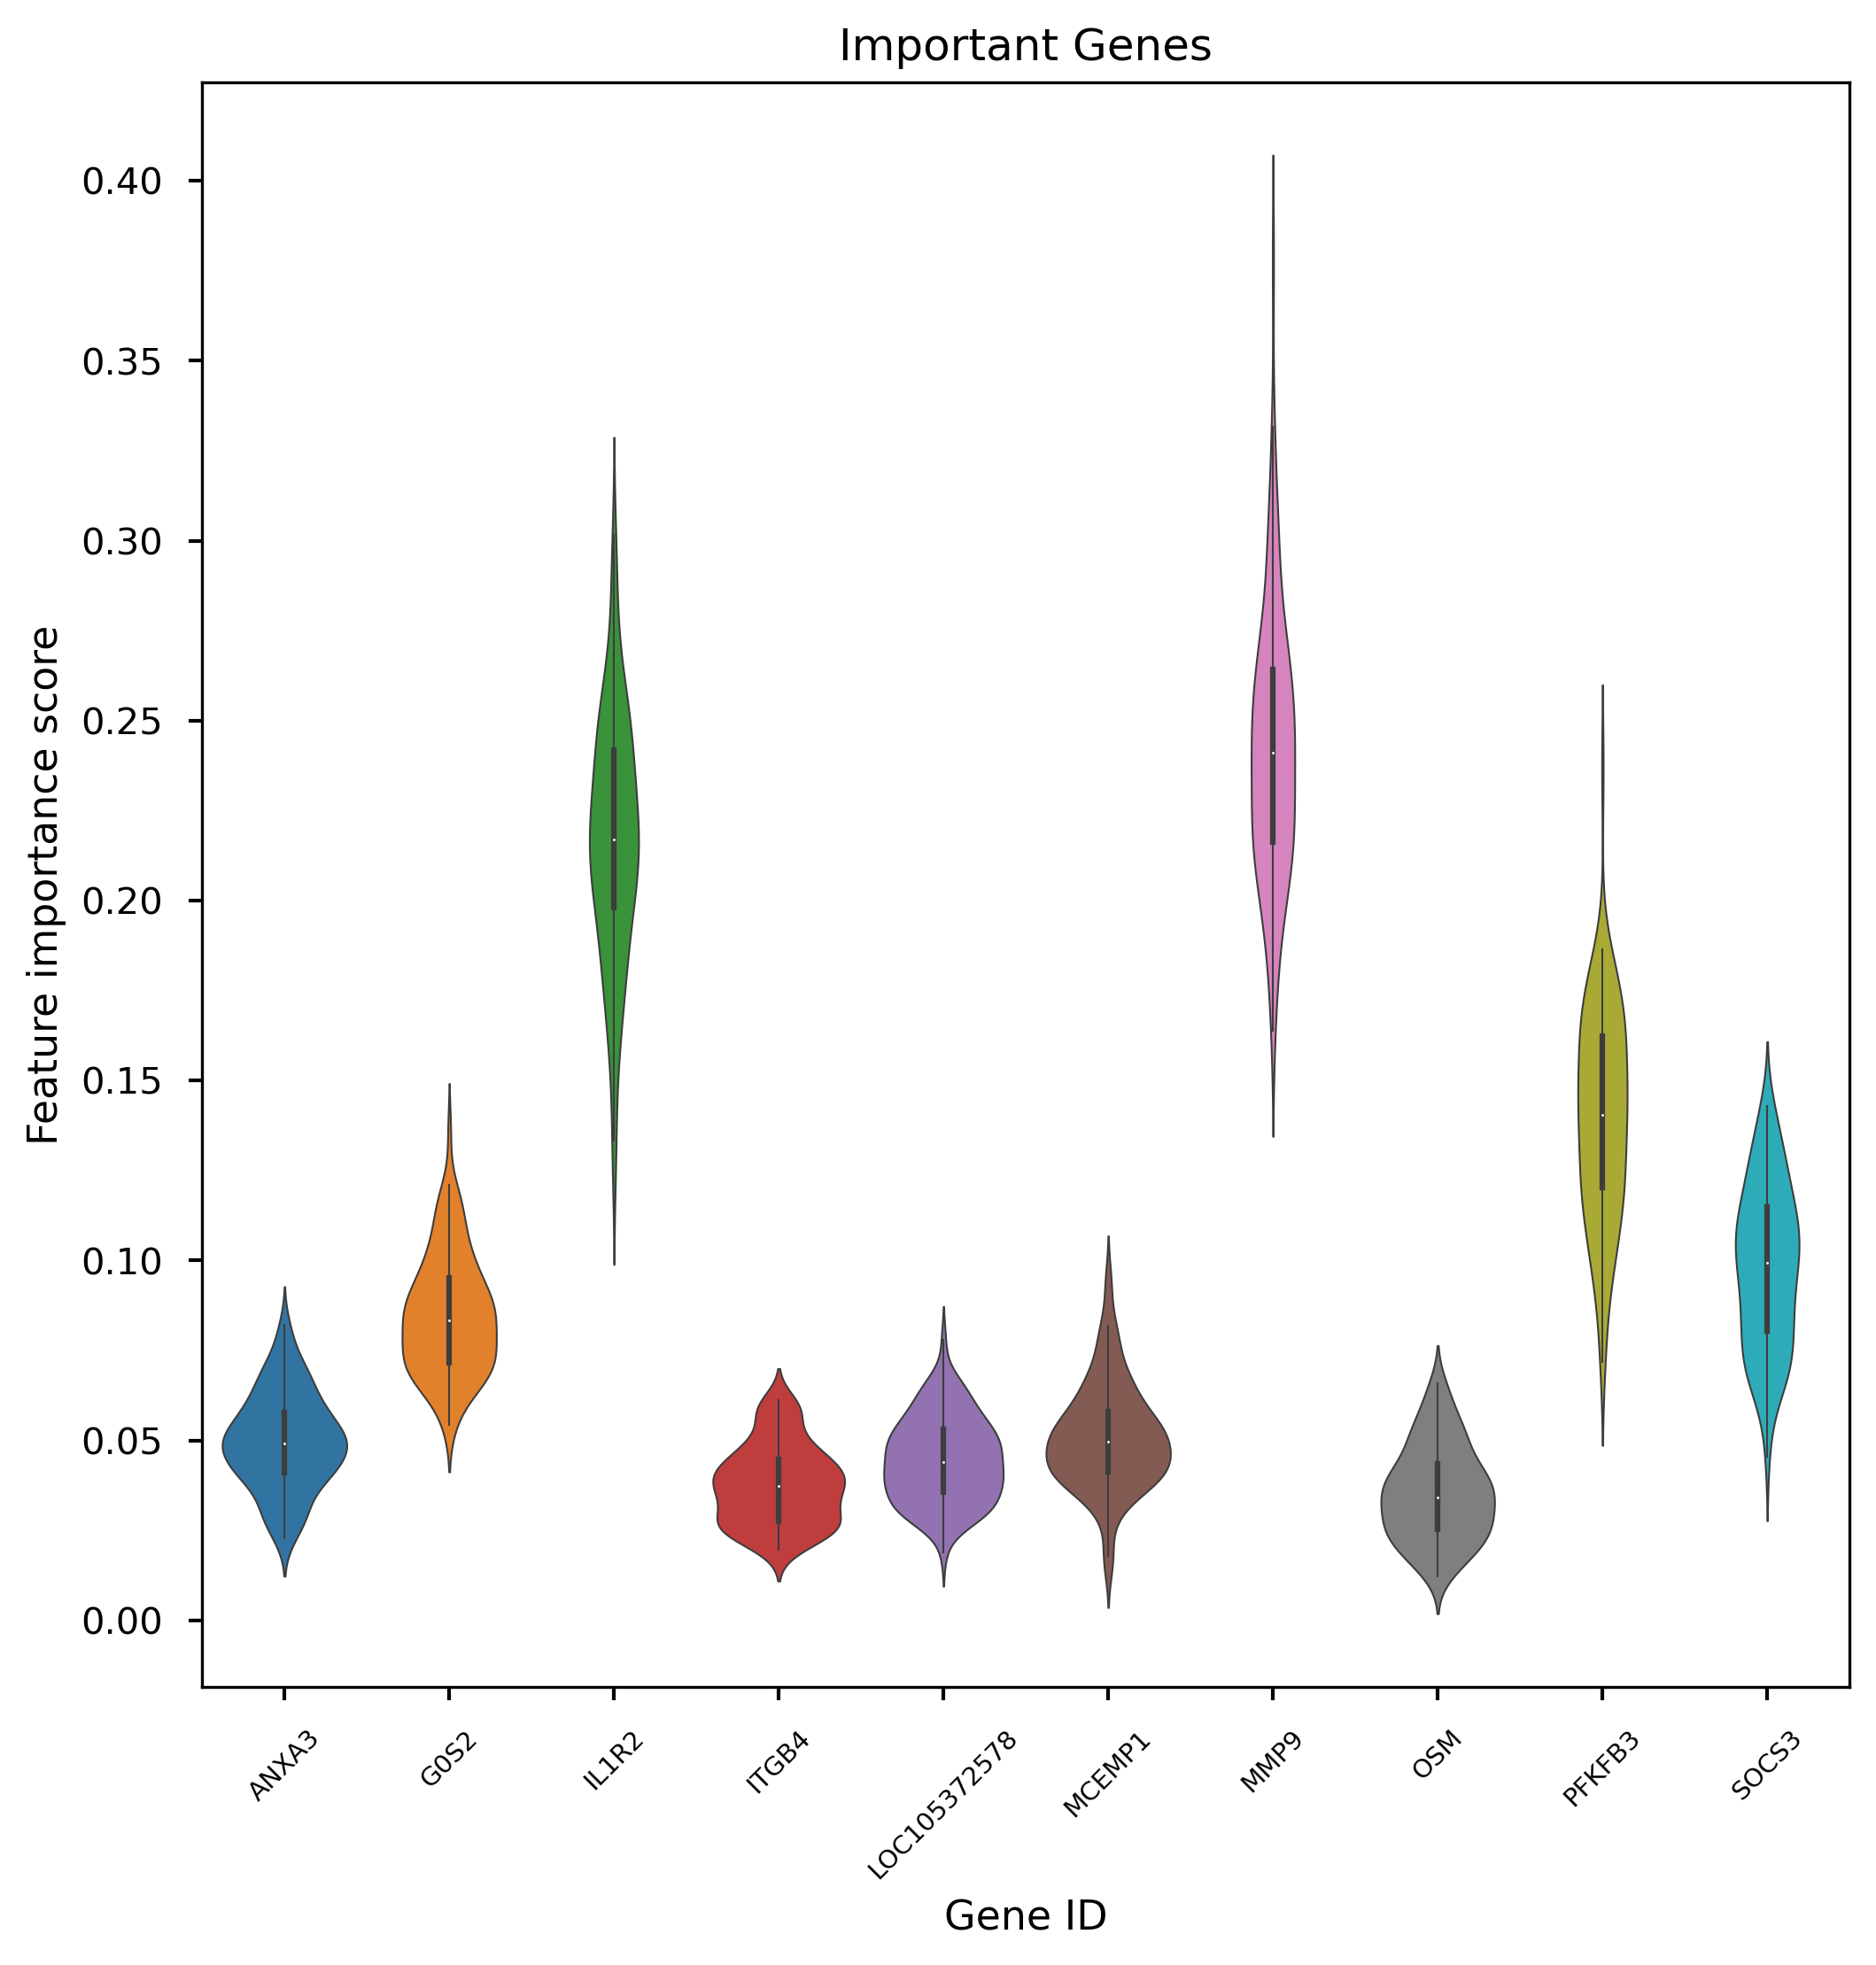

In [191]:
clf_feature_imp_df = pd.DataFrame(data=clf_feature_imp)
plt.style.use('seaborn-notebook')
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (8,8), dpi=300, facecolor="white")
plt.rcParams['lines.linewidth']=.5
sns.violinplot(y="important",x="genes", data=clf_feature_imp_df)
plt.xticks(rotation=45, fontsize=7)
plt.title("Important Genes")
plt.xlabel("Gene ID")
plt.ylabel("Feature importance score")
plt.savefig('random_forest_important_genes.png')

In [ ]:
# figure caption: The horizontal axis shows names of the most influential genes
# vertical axis shows their relative importance. Because random forest uses randomness,
# the exact importance of the gene can vary, the importance values exhibit dispersion.

# make it vertical, rotate the names.

In [173]:
from sklearn.tree import DecisionTreeClassifier

test_precision = []
test_recall = []
test_f1 = []
for i in range(100):
    clf = DecisionTreeClassifier(criterion="gini")
    scoring = {'precision': 'precision',
               'recall': 'recall',
              'f1_macro':'f1_macro'}
    scores = cross_validate(clf, X, Y, cv=5, scoring=scoring, return_train_score=True)
    test_precision.append(scores['test_precision'].mean())
    test_recall.append(scores['test_recall'].mean())
    test_f1.append(scores['test_f1_macro'].mean())
    
np.array(test_f1).mean()

0.8573587301587304

In [174]:
Y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.])

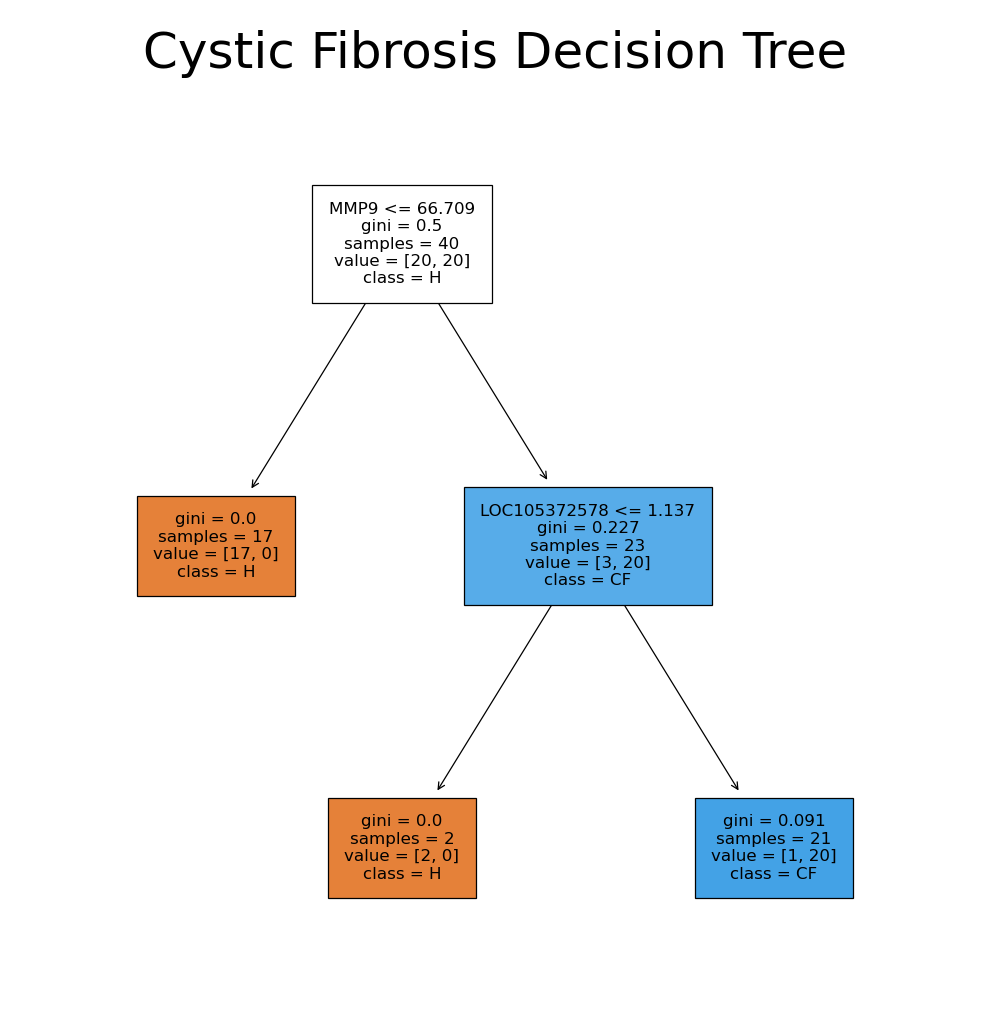

In [179]:
from sklearn import tree
plt.style.use('seaborn-notebook')
clf_gini = DecisionTreeClassifier(criterion="gini", max_depth=2).fit(X, Y)
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300, facecolor="white")
plt.rcParams['lines.markeredgecolor']='black'
plt.rcParams['lines.linewidth']=1

tree.plot_tree(clf_gini,
               feature_names = data_df_subset_bon_top10ci.ID.values,
               class_names= ["H","CF"],
               filled = True,
              fontsize=4,
              )
plt.title("Cystic Fibrosis Decision Tree")
fig.savefig('rnaseq_decision_tree.png')

In [ ]:
#plt.rcParams.keys()

In [ ]:
# figure caption: The root of the decision tree is MMP9. 
# Based on branching on its expression value, the tree separates 17 out of the 20 
# healthy people. Of those greater than ... 20  have cf and 3 do not. 
#The gene LOC can distinguish the remaining except for one.

In [ ]:
#X